**Old data cleaning code is below.**

In [ ]:
#call modules
from sklearn.metrics import classification_report, accuracy_score, recall_score,precision_score, confusion_matrix,jaccard_similarity_score,roc_auc_score,f1_score,hamming_loss,make_scorer
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
import re
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV,train_test_split
from sklearn import naive_bayes ,metrics
from sklearn.feature_selection import SelectPercentile, f_classif,SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier,PassiveAggressiveClassifier,SGDClassifier,LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
#call modules
import pandas as pd
import numpy as np
#import nlp_functions as nlp             npl_functions doesnt exists move to last point for data cleaning
from scipy import stats


In [ ]:
#load origin data from csv file
X=pd.read_csv('../input/main-data/train_values.csv',index_col=0,header=0,dtype=np.object_).iloc[:,-1]
test_values=pd.read_csv('../input/main-data/test_values.csv',index_col=0,header=0)
train_labels=pd.read_csv('../input/main-data/train_labels.csv',index_col=0,header=0)

In [ ]:
#clean up train data and save data (not shown here)
#retrieve data, load data
X=pd.read_csv('X_Test_data_1.csv',header=0,dtype=np.object_).iloc[:,-1]

In [ ]:
#handling np.nan
X_nan=pd.Series(np.where(X.isna()==True,X.values.astype('U'),X.values))

In [ ]:
X=X_nan
#X_Set=X_Set_nan

In [ ]:
vec = TfidfVectorizer(max_features=20000,stop_words='english',ngram_range=(1,2))

In [ ]:
#split training data into training dataset and testing dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X.values,train_labels.values,test_size=1.0,random_state=0)
#X_train_raw, X_test_raw, y_train, y_test = train_test_split(pd.read_csv('X.csv',header=0,dtype= np.object_).iloc[:,-1].values, train_labels.values,test_size=0.0,random_state=0)

In [ ]:
#fit_transform training data
#X_train=vectorizer.fit_transform(X_train_raw).toarray()
X_test=vec.fit_transform(X_test_raw)#toarray() #?list object has no attribute lower #using join removes the problem

In [ ]:
#X_train.shape #, 
X_test.shape

In [ ]:
X_test=vec.transform(X_test_raw)#.toarray()

In [ ]:
df=pd.DataFrame()
df_pred=pd.DataFrame()
col=[]
for i in range(y_train.shape[1]):
    #select best features
    select=SelectKBest(chi2, k=10000)  #k=10000 works the best
    #select=SelectKBest(f_classif, k=7500)
    #select=SelectPercentile(f_classif,percentile=10)
    
    #fit and transform data using best features
    X_train_sel=select.fit_transform(X_train,y_train[:,i]).toarray()
    X_test_sel=select.transform(X_test).toarray()
    
    #called model and fit model
    base_SVC=LinearSVC(tol=1e-3,max_iter=1000,class_weight=None)
    ovr_SVC=OneVsRestClassifier(base_SVC)
    ovr_SVC.fit(X_train_sel, y_train[:,i])
    
    #predict model
    col = 'y_pred_%d' % i
    df[col] = ovr_SVC.predict(X_test_sel)
    
    #X_test_sel=select.transform(X_test).toarray()
    #ovr_SVC.predict(X_test_sel)
    #df_pred[col]=ovr_SVC.predict(X_test_sel)    
    

In [ ]:
df.head(-1)

In [ ]:
#Link creater to downloada

from IPython.display import HTML
import base64  
import pandas as pd  

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)

In [ ]:
metrics.f1_score(y_test, df.values,average='micro'),metrics.accuracy_score(y_test, df.values)

#### principal component analysis approach

In [ ]:
alt_pca=TruncatedSVD(n_components=5000)
alt_pca.fit(X_train)
X_train_alt_pca=alt_pca.transform(X_train)
X_test_alt_pca=alt_pca.transform(X_test)
X_test_alt_pca.shape,X_train_alt_pca.shape,type(X_test_alt_pca),type(X_train_alt_pca)

In [ ]:
#pca=PCA(n_components=2500)
#pca.fit(X_train)
#X_train_pca=pca.transform(X_train)
#X_test_pca=pca.transform(X_test)

In [ ]:
#X_Test_alt_pca=alt_pca.transform(X_Test)

In [ ]:
#hyper parameter testing. RidgeClassifier. alternate pca
f1score=[]
accuscore=[]
#max_iterations=[1000,5000]
alpha=[0.001,0.0001]
tol=[1e-3,1e-6]
#class_weights=[None,'balanced']
for i in alpha:
    for j in tol:
        #base_SVC=LinearSVC(tol=1e-3,max_iter=i,class_weight=j)
        #ovr_SVC=OneVsRestClassifier(base_SVC)
        #ovr_SVC.fit(X_train_alt_pca, y_train)
        
        base_RC=RidgeClassifier(tol=j,class_weight=None,alpha=i)
        ovr_RC=OneVsRestClassifier(base_RC)
        ovr_RC.fit(X_train_alt_pca, y_train)
        f1score.append(metrics.f1_score(y_test, ovr_RC.predict(X_test_alt_pca),average='micro'))
        accuscore.append(metrics.accuracy_score(y_test, ovr_RC.predict(X_test_alt_pca)))

print(f1score)
print(accuscore)

In [ ]:
#metrics.f1_score(y_test, ovr_RC.predict(X_test),average='micro'),metrics.accuracy_score(y_test, ovr_RC.predict(X_test))
metrics.f1_score(y_test, ovr_RC.predict(X_test_alt_pca),average='micro'),metrics.accuracy_score(y_test, ovr_RC.predict(X_test_alt_pca))

In [ ]:
#jaccard_similarity_score(y_test, ovr_RC.predict(X_test)),hamming_loss(y_test, ovr_RC.predict(X_test))
jaccard_similarity_score(y_test, ovr_RC.predict(X_test_alt_pca)),hamming_loss(y_test, ovr_RC.predict(X_test_alt_pca))

#### Clean up and prepare test data

In [ ]:
#given test data; test_values
X_Test=test_values['doc_text']

In [ ]:
#data preparation; clean test data
X_Test=X_Test.apply(lambda x: nlp.clean_up_text(x))

In [ ]:
#use split_words function
X_Test=X_Test.apply(lambda x: split_words(str(x)))

In [ ]:
#use splitW function
X_Test=X_Test.apply(lambda x: splitW(x))

In [ ]:
#tokenize test data
X_Test=X_Test.apply(lambda x: nlp.tokenize(x, min_char=4))

In [ ]:
#lemmatize test data
X_Test=X_Test.apply(lambda x: [lm.lemmatize(word) for word in x])

In [ ]:
#create string of tokenized text
X_Test=X_Test.apply(lambda x: ''.join(x))

In [ ]:
X_Test.head()

In [ ]:
#stem text
X_Test=X_Test.apply(lambda x: [ps.stem(word) for word in x])

In [ ]:
#save data to csv file
pd.DataFrame(X_Test).to_csv('X_Test_data_1.csv',encoding='utf-8',index=False)

In [ ]:
#retrieve data, load data
X_Test=pd.read_csv('X_Test_data_1.csv',header=0,dtype= np.object_).iloc[:,-1]#.values

In [ ]:
#handling np.nan
X_Test_nan=pd.Series(np.where(X_Test.isna()==True,X_Test.values.astype('U'),X_Test.values))
X_Test=X_Test_nan

In [ ]:
#transform test data
#X_Test=vectorizer.transform(X_Test).toarray()
X_Test=TfidfVectorizer.transform(pd.read_csv('X_Test_data_1.csv',header=0,dtype= np.object_ ).iloc[:,-1].values)#.toarray()

In [ ]:
X_Test.head()

**Clean up and plotting with LDA**
(Old codes data cleaning part)

In [1]:
#Initial calls

import types
import pandas as pd
import re


In [2]:
papers = test_values=pd.read_csv('../input/main-data/test_values.csv',index_col=0,header=0)

In [3]:
# Remove punctuation
papers['paper_text_processed'] = papers['doc_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()


row_id
0                                                  ...
1     early learning partnership\n\n\n\n\n e l p\n ...
2                                                  ...
3                                                  ...
4                                                  ...
Name: paper_text_processed, dtype: object

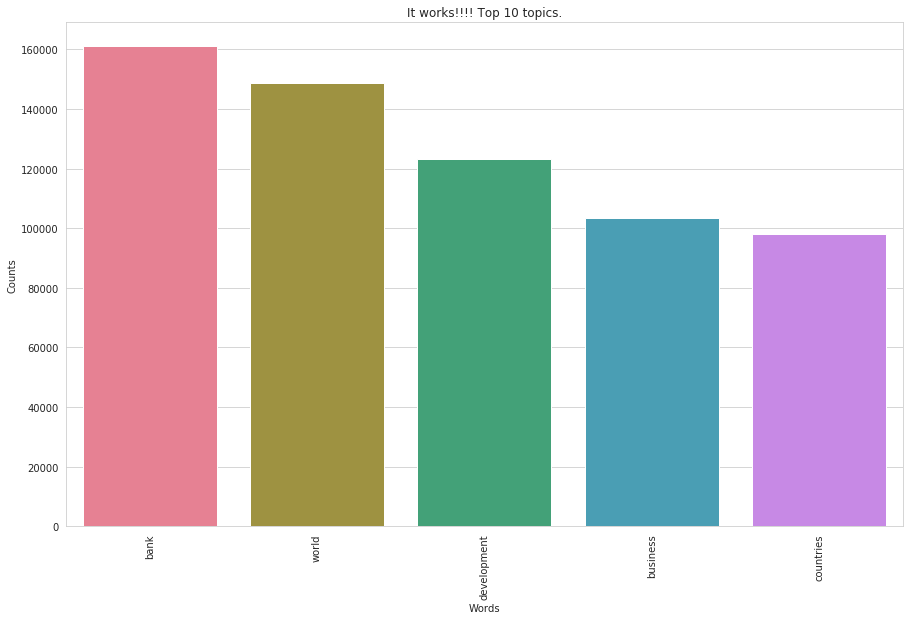

In [4]:
#Checking by plotting out top words

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:5]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='It works!!!! Top 10 topics.')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
#Predicting top used topics by LDA


import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)


**Continuing GitHub guys code with little changes**

In [ ]:
#GO TO CREATE STRINGS FROM TOKENIZED DATA FIRST

In [ ]:
#retrieve data, load data
X=pd.read_csv('X_Test_data_1.csv',header=0,dtype=np.object_).iloc[:,-1]

In [ ]:
#handling np.nan
X_Set=pd.Series(np.where(X.isna()==True,X.values.astype('U'),X.values))

In [ ]:
vec = TfidfVectorizer(max_features=20000,stop_words='english',ngram_range=(1,2))

In [ ]:
# Go to split training data into training dataset and testing dataset **IMPORTANT** set test_size= 1.0 & k = 10000